# Notebook 2 - Getting a final Data Frame at a national level.

In this notebook we create a single dataframe in education and GDP with information on:
1. Education Levels - Namely the percentage of Over25 that hold a Bachelor's degree [Source: US Census Bureau]
2. Education Institution Presence - from the Firms API we analysed the "educational services" category (number 61) that showed us per each county how many educ. centres were present (this includes kindergarten, schools of any level and university) [Source: US Census Bureau]
3. Salary - The total income of the county [Source: Bureau of Economic Analysis]


We start by importing the necessary libraries, retrieving the data from the API and analysing only the state of California for the sake of notebook size, we will proceed to a further analysis in a later step of our project

In [1]:
#Required imports for the project
import requests # for api requests
import pandas as pd #tabular data

from bs4 import BeautifulSoup

In [2]:
# !! REMINDER TO TAKE API KEY OUT OF CODE BEFORE SUBMITTING !!
api_key = "07e7023663c44b8f1179b4918403f04506e6264b"

In [3]:
#creating a dataframe function
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

In [4]:
#Creating a function to remove the leading zeros from a column
def remove_leading_zeros(df, column):
    df[column] = df[column].str.lstrip('0')
    return df

In [5]:
#Setting up the API Query parameters for the educational services industry
params1 = {"NAICS2017" : 61}

In [6]:
#Requesting the json file from the census website using the api key
url = "https://api.census.gov/data/2017/ecnbasic?get=NAICS2017_LABEL,NAICS2017,GEO_ID,FIRM&for=county:*&key={}".format(api_key)
response = requests.request("GET", url, params=params1)

In [7]:
response.text[0:77]

'[["NAICS2017_LABEL","NAICS2017","GEO_ID","FIRM","NAICS2017","state","county"]'

In [8]:
#Converting ecn data frame into pandas data frame
educational_services = json_to_dataframe(response)
df = pd.DataFrame(data = educational_services)
df['FIRM'] = df['FIRM'].astype(int)
df['state'] = df['state'].astype("string")
df_educationservices=df #renaming the dataframe = Number of firms in the educational services industry

In [9]:
# Top 5 counties with largest number of educational services
df_eds_sort = df_educationservices\
.sort_values(by=['FIRM'], ascending=False)\
.head(10)
print('Top 10 counties with the most amount of educational services in the US')
df_eds_sort 

Top 10 counties with the most amount of educational services in the US


,NAICS2017_LABEL,NAICS2017,GEO_ID,FIRM,NAICS2017,state,county
298,Educational services,61,0500000US06037,2787,61,06,037
788,Educational services,61,0500000US17031,1460,61,17,031
829,Educational services,61,0500000US36061,1294,61,36,061
314,Educational services,61,0500000US06059,1187,61,06,059
534,Educational services,61,0500000US53033,1154,61,53,033
329,Educational services,61,0500000US06073,1010,61,06,073
133,Educational services,61,0500000US04013,1007,61,04,013
96,Educational services,61,0500000US48201,868,61,48,201
301,Educational services,61,0500000US06085,822,61,06,085
474,Educational services,61,0500000US12086,761,61,12,086


In [10]:
#Number of counties in the enc dataset for California
df_educationservices['county'].count()

1459

In [11]:
#Getting the ACS data
#Requesting the json file from the census website using the api key 
url = "https://api.census.gov/data/2017/acs/acs1/profile?get=DP02_0064PE,DP02_0088PE,DP02_0123PE&for=county&key={}".format(api_key)
response2 = requests.request("GET", url)

In [12]:
#Seeing what the columns for the data are
response2.text[0:61]

'[["DP02_0064PE","DP02_0088PE","DP02_0123PE","state","county"]'

## Meaning of variables
- **DP02_0064PE** = Percent!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree

In [13]:
pop_chars = json_to_dataframe(response2)
df = pd.DataFrame(data = pop_chars)
df_perc_bach = df #renaming the dataframe = Percentage of population with a bachelor's degree or higher

In [14]:
#Number of counties in the acs dataset for California
df_perc_bach['county'].count() # ISSUE HERE: The previous dataframe returned 1459 rows, but this one only returns 837 rows

837

In [15]:
df_perc_bach #ISSUE HERE: Why does it show two percentages for the same county?

,DP02_0064PE,DP02_0088PE,DP02_0123PE,state,county
0,19.0,96.0,21.0,47,179
1,16.7,95.9,-999999999.0,47,119
2,15.5,93.9,5.4,48,451
3,12.9,92.4,-999999999.0,48,469
4,16.6,91.1,5.3,48,485
...,...,...,...,...,...
832,14.2,98.3,2.8,26,017
833,16.0,95.6,4.8,26,045
834,18.2,91.8,3.6,27,131
835,31.3,84.7,2.5,27,053


In [16]:
#Merging the two datasets
merged_census = pd.merge(df_educationservices, df_perc_bach, on='county')
#drop state_y column and rename state_x to state
merged_census = merged_census.drop(columns=['state_y', 'NAICS2017'])
merged_census = merged_census.rename(columns={'state_x': 'state', 'FIRM':'Number of Educational Institutions','DP02_0064PE':'Percent of Population with a Bachelor\'s Degree'})
#Convert the columns to the correct data types
merged_census['Percent of Population with a Bachelor\'s Degree'] = merged_census['Percent of Population with a Bachelor\'s Degree'].astype(float)
merged_census['county'] = merged_census['county'].astype(int)
# The last two columns are currently unneeded but will be later used for contextual analysis.
#Drop the last two columns
merged_census = merged_census.drop(columns=['DP02_0088PE', 'DP02_0123PE'])
merged_census.head()

,NAICS2017_LABEL,GEO_ID,Number of Educational Institutions,state,county,Percent of Population with a Bachelor's Degree
0,Educational services,0500000US47177,5,47,177,21.3
1,Educational services,0500000US47177,5,47,177,12.4
2,Educational services,0500000US47177,5,47,177,21.5
3,Educational services,0500000US51177,22,51,177,21.3
4,Educational services,0500000US51177,22,51,177,12.4


The two datasets are merged into a single one. In the next steps, we solve the issue of multiple percentages for the same state/county, by taking the average value and keeping only one row per county.

In [17]:
# If a row has the same county and state, then take the average of the two rows, keeping GEO_ID and Number of Educational Institutions the same
merged_census = merged_census.groupby(['state', 'county','GEO_ID']).mean().reset_index()
merged_census.head()


/tmp/ipykernel_27076/3355925006.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_census = merged_census.groupby(['state', 'county','GEO_ID']).mean().reset_index()


,state,county,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree
0,01,1,0500000US01001,0.0,18.273684
1,01,3,0500000US01003,34.0,20.436842
2,01,9,0500000US01009,3.0,18.923077
3,01,15,0500000US01015,0.0,16.352941
4,01,25,0500000US01025,0.0,17.007692


In [18]:
#Count all the counties whose Number of Educational Institutions is not equal to 0
merged_census[merged_census['Number of Educational Institutions'] != 0].count()


state                                             1076
county                                            1076
GEO_ID                                            1076
Number of Educational Institutions                1076
Percent of Population with a Bachelor's Degree    1076
dtype: int64

 
A couple of problems here:
- 300 counties have 0 education institutions (this might be true but it reduces significantly the reliability of our research)
- We are missing more than 600 rows from one data set to another
- If we take out all the missing data, and the rows where the number of educational services is 0, we have 1076, **less than a third of the total counties!**

**What to do?**
We move on with our analysis. After discussion, we decided that the decrease in number of counties is still enough as a representative sample of the states and the country overall

In [19]:
# Remove NAICS2017_LABEL, state, county, County and County_name columns
#Create a copy of merged_census called education_data
education_data = merged_census.copy()
education_data

,state,county,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree
0,01,1,0500000US01001,0.0,18.273684
1,01,3,0500000US01003,34.0,20.436842
2,01,9,0500000US01009,3.0,18.923077
3,01,15,0500000US01015,0.0,16.352941
4,01,25,0500000US01025,0.0,17.007692
...,...,...,...,...,...
1398,56,25,0500000US56025,22.0,17.007692
1399,56,29,0500000US56029,0.0,17.300000
1400,56,33,0500000US56033,0.0,16.300000
1401,56,37,0500000US56037,0.0,19.769231


The Census Bureau and the BEA use different GEO_IDs: the first adds "0500000US" before the code, while the second just uses a 5 number code. We easily solve the isse by removing "0500000US". We then proceed to use the adjusted GEO_ID as a merging point between the education percentage/number educational firms data frame and the 2017 GDP per county.

In [20]:
#Working on the GEO_ID column: keep only the code after 0500000US
education_data['GEO_ID'] = education_data['GEO_ID'].str.split('US').str[1]
education_data.head()

,state,county,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree
0,01,1,01001,0.0,18.273684
1,01,3,01003,34.0,20.436842
2,01,9,01009,3.0,18.923077
3,01,15,01015,0.0,16.352941
4,01,25,01025,0.0,17.007692


## Getting the Code on National Income

The excel file contains data on US GDP per county spanning from 2009 to 2018. We use the column from the year 2017 (GDP per capita) to match the education data from that same year.

In [21]:
import pandas as pd
#import excel file and convert to dataframe
us_gdp = pd.read_excel("../data/us_gdp_2009-18.xlsx")
# if GeoFIPS is under 10000, add a 0 in front of it
us_gdp['Clean GeoFIPS'] = us_gdp['Clean GeoFIPS'].apply(lambda x: '{0:0>5}'.format(x))
#convert GeoFIPS to string
us_gdp['Clean GeoFIPS'] = us_gdp['Clean GeoFIPS'].astype('string')
#keep only Clean GEOFIPS and GDP per Capita 2017
us_gdp = us_gdp[['Clean GeoFIPS', 'GDP per Capita 2017']]
#rename Clean GeoFIPS to GEO_ID
us_gdp = us_gdp.rename(columns={'Clean GeoFIPS': 'GEO_ID'})
us_gdp.head(20)

,GEO_ID,GDP per Capita 2017
0,01001,25.839051
1,01003,27.172905
2,01005,28.457883
3,01007,15.671346
4,01009,14.114381
5,01011,22.287746
6,01013,27.568717
7,01015,33.422040
8,01017,57.181236
9,01019,17.838832


In [22]:
#Merge the gdp dataframe with the education_data dataframe
gdp_and_census = pd.merge(education_data, us_gdp, on='GEO_ID')
gdp_and_census.head(20)

,state,county,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree,GDP per Capita 2017
0,01,1,01001,0.0,18.273684,25.839051
1,01,3,01003,34.0,20.436842,27.172905
2,01,9,01009,3.0,18.923077,14.114381
3,01,15,01015,0.0,16.352941,33.422040
4,01,25,01025,0.0,17.007692,31.323492
5,01,31,01031,0.0,19.218750,27.614689
6,01,33,01033,0.0,16.300000,49.759034
7,01,43,01043,0.0,17.255556,30.488783
8,01,45,01045,8.0,16.328571,49.787379
9,01,55,01055,0.0,18.741667,26.632326


In [23]:
# We test the size of the final dataframe.
len(gdp_and_census)

1393

/home/leomassoc/.local/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


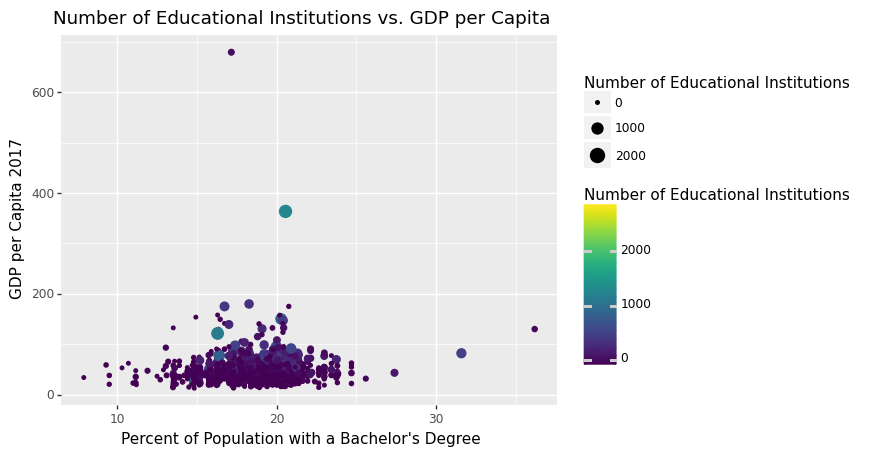

<ggplot: (8747848100753)>

In [24]:
# Create a scatterplot of the data with on the x-axis the percent of population with a Bachelor's Degree and on the y-axis the GDP per capita, the size and colour of the bubbles is the number of educational institutions using plotnine
from plotnine import *
(ggplot(gdp_and_census, aes(x='Percent of Population with a Bachelor\'s Degree', y='GDP per Capita 2017', size='Number of Educational Institutions', color='Number of Educational Institutions')) + geom_point() + labs(title="Number of Educational Institutions vs. GDP per Capita", x="Percent of Population with a Bachelor\'s Degree", y="GDP per Capita 2017", size="Number of Educational Institutions", color="Number of Educational Institutions"))


In [25]:
# Find the outliers. 
# Find the county with the highest GDP per capita
gdp_and_census[gdp_and_census['GDP per Capita 2017'] == gdp_and_census['GDP per Capita 2017'].max()]

,state,county,GEO_ID,Number of Educational Institutions,Percent of Population with a Bachelor's Degree,GDP per Capita 2017
475,22,51,22051,83.0,17.16,679.565483


In [26]:
#Find the name of the County and State using the fips2county.tsv file
fips_to_county=pd.read_csv("../data/fips2county.tsv", sep='\t')
fips_to_county.head()


,StateFIPS,CountyFIPS_3,CountyName,StateName,CountyFIPS,StateAbbr,STATE_COUNTY
0,1,1,Autauga,Alabama,1001,AL,AL | AUTAUGA
1,1,3,Baldwin,Alabama,1003,AL,AL | BALDWIN
2,1,5,Barbour,Alabama,1005,AL,AL | BARBOUR
3,1,7,Bibb,Alabama,1007,AL,AL | BIBB
4,1,9,Blount,Alabama,1009,AL,AL | BLOUNT


In [27]:
# Find the CountyName of the CountyFIPS 22051
fips_to_county[fips_to_county['CountyFIPS'] == 22051]

,StateFIPS,CountyFIPS_3,CountyName,StateName,CountyFIPS,StateAbbr,STATE_COUNTY
1139,22,51,Jefferson Parish,Louisiana,22051,LA,LA | JEFFERSON PARISH


In [28]:
#Find a correlation between the number of educational institutions and the GDP per capita
gdp_and_census['Number of Educational Institutions'].corr(gdp_and_census['GDP per Capita 2017'])


0.30868214595854865

We can notice that at US level, the correlation is quite weak: this does not prove our point. We try to see if there is a change at a state level.

In [29]:
# Converting the dataframe to a csv file, in order to use it in other notebooks
gdp_and_census.to_csv('../data/gdp_and_census.csv', index=False)